<a href="https://colab.research.google.com/github/IsidoraJevremovic/osnovi-astronomije/blob/main/VANJA_3CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install cirq

BEZ CONFIDENCE INTERVAL-IZGLEDA SJAJNO-BRAVO VANJA

First few rows of the data:
    time               mag  magerr
0  time               mag  magerr
1     1  21.8360271790208    0.05
2    11  21.8299875980732    0.05
3    21  21.8285566936124    0.05
4    31  21.8282043758076    0.05

Data types:
 time      object
mag       object
magerr    object
dtype: object
Epoch [500/8000], Loss: 0.0189
Epoch [1000/8000], Loss: 0.0131
Epoch [1500/8000], Loss: 0.0105
Epoch [2000/8000], Loss: 0.0109
Epoch [2500/8000], Loss: 0.0066
Epoch [3000/8000], Loss: 0.0049
Epoch [3500/8000], Loss: 0.0055
Epoch [4000/8000], Loss: 0.0037
Epoch [4500/8000], Loss: 0.0060
Epoch [5000/8000], Loss: 0.0017
Epoch [5500/8000], Loss: 0.0012
Epoch [6000/8000], Loss: 0.0011
Epoch [6500/8000], Loss: 0.0016
Epoch [7000/8000], Loss: 0.0012
Epoch [7500/8000], Loss: 0.0008
Epoch [8000/8000], Loss: 0.0007
Mean Absolute Error (MAE): 0.0149


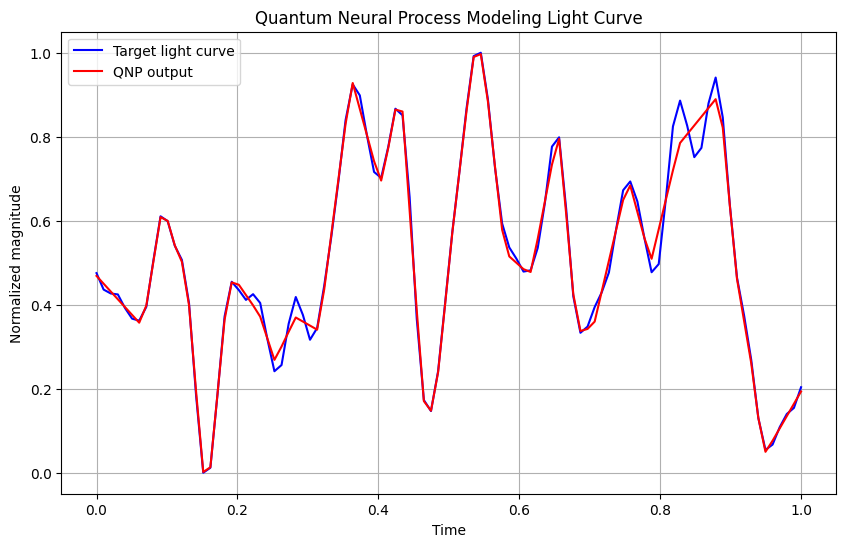

In [14]:
import cirq
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

num_qubits = 4
depth = 4
qubits = cirq.LineQubit.range(num_qubits)

def create_circuit(params):
    circuit = cirq.Circuit()
    index = 0
    for layer in range(depth):
        for i in range(num_qubits):
            circuit.append(cirq.rx(params[index])(qubits[i]))
            index += 1
            circuit.append(cirq.ry(params[index])(qubits[i]))
            index += 1
            circuit.append(cirq.rz(params[index])(qubits[i]))
            index += 1
        if num_qubits > 1:
            for i in range(num_qubits - 1):
                circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
    return circuit

def simulate_circuit(circuit):
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    final_state = result.final_state_vector
    return np.real(final_state)

class QuantumEncoder(nn.Module):
    def __init__(self, num_qubits, depth, latent_dim):
        super(QuantumEncoder, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.latent_dim = latent_dim
        self.num_params = num_qubits * depth * 3
        self.params = nn.Parameter(torch.randn(self.num_params, dtype=torch.float32))

    def forward(self, x_context, y_context):
        params = self.params.detach().numpy()
        circuit = create_circuit(params)
        r = simulate_circuit(circuit)
        r = torch.tensor(r[:self.latent_dim], dtype=torch.float32)
        return r

class NeuralDecoder(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, hidden_dim=128):
        super(NeuralDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(input_dim + latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x_target, r_target):
        decoder_input = torch.cat([x_target, r_target], dim=-1)
        y_pred = self.decoder(decoder_input)
        return y_pred

class QuantumNeuralProcess(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, depth, num_qubits):
        super(QuantumNeuralProcess, self).__init__()
        self.encoder = QuantumEncoder(num_qubits, depth, latent_dim)
        self.decoder = NeuralDecoder(input_dim, latent_dim, output_dim)

    def forward(self, x_context, y_context, x_target):
        r = self.encoder(x_context, y_context)
        r_target = r.expand(x_target.size(0), -1)
        y_pred = self.decoder(x_target, r_target)
        return y_pred

# Load and normalize the data
# data = pd.read_csv("6.csv", header=None, names=['time', 'mag', 'magerr'])

## Dodala funkciju za ucitavanje i proveru formata podataka, mozda nam format fajla ne odgovara -Isidora

def load_and_preprocess_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, header=None, names=['time', 'mag', 'magerr'])

    # Display the first few rows of the dataframe and check data types
    print("First few rows of the data:\n", data.head())
    print("\nData types:\n", data.dtypes)

    # Convert columns to numeric, forcing errors to NaN
    data['time'] = pd.to_numeric(data['time'], errors='coerce')
    data['mag'] = pd.to_numeric(data['mag'], errors='coerce')
    data['magerr'] = pd.to_numeric(data['magerr'], errors='coerce')

    # Drop rows with NaN values
    data.dropna(inplace=True)

    # Check if the DataFrame is empty after cleaning
    if data.empty:
        raise ValueError("After cleaning, data is empty. Check input data and preprocessing steps.")

    return data

data = load_and_preprocess_data("6.2.csv")
time_points = data['time'].values
magnitude = data['mag'].values

# Normalize the time points and magnitude
time_points = (time_points - np.min(time_points)) / (np.max(time_points) - np.min(time_points))
magnitude = (magnitude - np.min(magnitude)) / (np.max(magnitude) - np.min(magnitude))

x_context = torch.tensor(time_points, dtype=torch.float32).unsqueeze(-1)
y_context = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(-1)
x_target = torch.tensor(time_points, dtype=torch.float32).unsqueeze(-1)
y_target = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(-1)

input_dim = 1
latent_dim = 4
output_dim = 1

qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context, y_context, x_target)
    loss = loss_fn(y_pred, y_target)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

qnp_model.eval()
with torch.no_grad():
    y_pred = qnp_model(x_context, y_context, x_target).numpy()

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_target.numpy(), y_pred)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(time_points, magnitude, label='Target light curve', color='blue')
plt.plot(time_points, y_pred, label='QNP output', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve')
plt.grid(True)
plt.show()


In [16]:
!pip install torchsummary

First few rows of the data:
    time               mag  magerr
0  time               mag  magerr
1     1  21.8360271790208    0.05
2    11  21.8299875980732    0.05
3    21  21.8285566936124    0.05
4    31  21.8282043758076    0.05

Data types:
 time      object
mag       object
magerr    object
dtype: object
Epoch [500/8000], Loss: 0.0262
Epoch [1000/8000], Loss: 0.0234
Epoch [1500/8000], Loss: 0.0175
Epoch [2000/8000], Loss: 0.0107
Epoch [2500/8000], Loss: 0.0132
Epoch [3000/8000], Loss: 0.0079
Epoch [3500/8000], Loss: 0.0064
Epoch [4000/8000], Loss: 0.0055
Epoch [4500/8000], Loss: 0.0048
Epoch [5000/8000], Loss: 0.0054
Epoch [5500/8000], Loss: 0.0068
Epoch [6000/8000], Loss: 0.0017
Epoch [6500/8000], Loss: 0.0018
Epoch [7000/8000], Loss: 0.0014
Epoch [7500/8000], Loss: 0.0010
Epoch [8000/8000], Loss: 0.0009
Mean Absolute Error (MAE): 0.0245


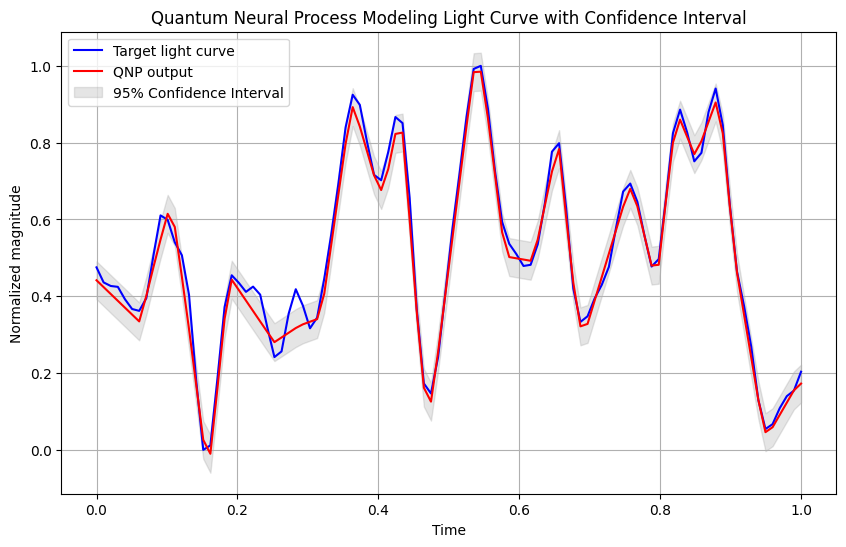

In [18]:
import cirq
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

num_qubits = 4
depth = 4
qubits = cirq.LineQubit.range(num_qubits)

def create_circuit(params):
    circuit = cirq.Circuit()
    index = 0
    for layer in range(depth):
        for i in range(num_qubits):
            circuit.append(cirq.rx(params[index])(qubits[i]))
            index += 1
            circuit.append(cirq.ry(params[index])(qubits[i]))
            index += 1
            circuit.append(cirq.rz(params[index])(qubits[i]))
            index += 1
        if num_qubits > 1:
            for i in range(num_qubits - 1):
                circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
    return circuit

def simulate_circuit(circuit):
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    final_state = result.final_state_vector
    return np.real(final_state)

class QuantumEncoder(nn.Module):
    def __init__(self, num_qubits, depth, latent_dim):
        super(QuantumEncoder, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.latent_dim = latent_dim
        self.num_params = num_qubits * depth * 3
        self.params = nn.Parameter(torch.randn(self.num_params, dtype=torch.float32))

    def forward(self, x_context, y_context):
        params = self.params.detach().numpy()
        circuit = create_circuit(params)
        r = simulate_circuit(circuit)
        r = torch.tensor(r[:self.latent_dim], dtype=torch.float32)
        return r

class NeuralDecoder(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, hidden_dim=128):
        super(NeuralDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(input_dim + latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x_target, r_target):
        decoder_input = torch.cat([x_target, r_target], dim=-1)
        y_pred = self.decoder(decoder_input)
        return y_pred

class QuantumNeuralProcess(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, depth, num_qubits):
        super(QuantumNeuralProcess, self).__init__()
        self.encoder = QuantumEncoder(num_qubits, depth, latent_dim)
        self.decoder = NeuralDecoder(input_dim, latent_dim, output_dim)

    def forward(self, x_context, y_context, x_target):
        r = self.encoder(x_context, y_context)
        r_target = r.expand(x_target.size(0), -1)
        y_pred = self.decoder(x_target, r_target)
        return y_pred

# Load and normalize the data
#data = pd.read_csv("6.csv", header=None, names=['time', 'mag', 'magerr'])

## Dodala funkciju za ucitavanje i proveru formata podataka, mozda nam format fajla ne odgovara -Isidora

def load_and_preprocess_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, header=None, names=['time', 'mag', 'magerr'])

    # Display the first few rows of the dataframe and check data types
    print("First few rows of the data:\n", data.head())
    print("\nData types:\n", data.dtypes)

    # Convert columns to numeric, forcing errors to NaN
    data['time'] = pd.to_numeric(data['time'], errors='coerce')
    data['mag'] = pd.to_numeric(data['mag'], errors='coerce')
    data['magerr'] = pd.to_numeric(data['magerr'], errors='coerce')

    # Drop rows with NaN values
    data.dropna(inplace=True)

    # Check if the DataFrame is empty after cleaning
    if data.empty:
        raise ValueError("After cleaning, data is empty. Check input data and preprocessing steps.")

    return data

data = load_and_preprocess_data("6.2.csv")

time_points = data['time'].values
magnitude = data['mag'].values

# Normalize the time points and magnitude
time_points = (time_points - np.min(time_points)) / (np.max(time_points) - np.min(time_points))
magnitude = (magnitude - np.min(magnitude)) / (np.max(magnitude) - np.min(magnitude))

x_context = torch.tensor(time_points, dtype=torch.float32).unsqueeze(-1)
y_context = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(-1)
x_target = torch.tensor(time_points, dtype=torch.float32).unsqueeze(-1)
y_target = torch.tensor(magnitude, dtype=torch.float32).unsqueeze(-1)

input_dim = 1
latent_dim = 4
output_dim = 1

qnp_model = QuantumNeuralProcess(input_dim, latent_dim, output_dim, depth, num_qubits)
optimizer = torch.optim.Adam(qnp_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

num_epochs = 8000
for epoch in range(num_epochs):
    qnp_model.train()
    optimizer.zero_grad()
    y_pred = qnp_model(x_context, y_context, x_target)
    loss = loss_fn(y_pred, y_target)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

qnp_model.eval()
with torch.no_grad():
    y_pred = qnp_model(x_context, y_context, x_target).numpy()

# Calculate residuals and their standard deviation
residuals = y_target.numpy().flatten() - y_pred.flatten()
std_dev = np.std(residuals)

# Define the confidence interval using the standard deviation of the residuals
lower_bound = y_pred.flatten() - 1.96 * std_dev
upper_bound = y_pred.flatten() + 1.96 * std_dev

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_target.numpy(), y_pred)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(time_points, magnitude, label='Target light curve', color='blue')
plt.plot(time_points, y_pred, label='QNP output', color='red')
plt.fill_between(time_points, lower_bound, upper_bound, color='gray', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized magnitude')
plt.title('Quantum Neural Process Modeling Light Curve with Confidence Interval')
plt.grid(True)
plt.show()


In [19]:
# Print the model summary
summary(qnp_model, [(1,), (1,), (1,)])


NameError: name 'summary' is not defined